In [1]:
!git clone -q -b feature/demo https://github.com/avsthiago/deepbee-source.git
%cd deepbee-source/notebooks/

/content/deepbee-source/notebooks


In [28]:
!pip install -q -r ../requirements.txt

In [3]:
# Download sample images
!gdown -q 17aa1xCnM0CsHjLrWzDmAJD852QdEa0T_ -O data/raw/
!unzip -q data/raw/sample-images.zip -d data/raw/
!rm data/raw/sample-images.zip !rm -rf data/raw/_*

In [4]:
# Download training dataset
!gdown 1lt42YRAg3wdJfF2ZSzF-VlB5Xo7bk75n -O data/
!unzip -q data/training_segmentation.zip -d data/
!rm data/training_segmentation.zip !rm -rf data/_*

Downloading...
From (original): https://drive.google.com/uc?id=1lt42YRAg3wdJfF2ZSzF-VlB5Xo7bk75n
From (redirected): https://drive.google.com/uc?id=1lt42YRAg3wdJfF2ZSzF-VlB5Xo7bk75n&confirm=t&uuid=cf93b215-f1cb-4c23-81c3-2f3ec84e0236
To: /content/deepbee-source/notebooks/data/training_segmentation.zip
100% 607M/607M [00:19<00:00, 31.8MB/s]


In [5]:
import os
import sys
import cv2
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
from skimage.transform import resize

In [6]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [7]:
PATH_IMAGES_TRAIN = 'data/training_segmentation/train/images'
PATH_LABELS_TRAIN = 'data/training_segmentation/train/labels'
PATH_IMAGES_TEST = 'data/training_segmentation/test/images'
PATH_LABELS_TEST = 'data/training_segmentation/test/labels'

In [8]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
# Helper functions
def load_image(image_path, mask=False):
    img = tf.io.read_file(image_path)
    if mask:
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = tf.cast(img, tf.float32) / 255.0
    else:
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = tf.cast(img, tf.float32) / 255.0
    return img

def load_data(image_path, mask_path):
    image = load_image(image_path)
    mask = load_image(mask_path, mask=True)
    return image, mask

In [10]:
# Prepare datasets
train_images = sorted([os.path.join(PATH_IMAGES_TRAIN, fname) for fname in os.listdir(PATH_IMAGES_TRAIN)])
train_masks = sorted([os.path.join(PATH_LABELS_TRAIN, fname) for fname in os.listdir(PATH_LABELS_TRAIN)])

test_images = sorted([os.path.join(PATH_IMAGES_TEST, fname) for fname in os.listdir(PATH_IMAGES_TEST)])
test_masks = sorted([os.path.join(PATH_LABELS_TEST, fname) for fname in os.listdir(PATH_LABELS_TEST)])


In [11]:
# Create tf.data.Dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.map(load_data, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.map(load_data, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [12]:
# Build U-Net model
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = keras.Input(input_size)

    # Encoder (Downsampling)
    conv1 = keras.layers.Conv2D(16, 3, activation='elu', padding='same')(inputs)
    conv1 = keras.layers.Dropout(0.1)(conv1)
    conv1 = keras.layers.Conv2D(16, 3, activation='elu', padding='same')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(32, 3, activation='elu', padding='same')(pool1)
    conv2 = keras.layers.Dropout(0.1)(conv2)
    conv2 = keras.layers.Conv2D(32, 3, activation='elu', padding='same')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = keras.layers.Conv2D(64, 3, activation='elu', padding='same')(pool2)
    conv3 = keras.layers.Dropout(0.2)(conv3)
    conv3 = keras.layers.Conv2D(64, 3, activation='elu', padding='same')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = keras.layers.Conv2D(128, 3, activation='elu', padding='same')(pool3)
    conv4 = keras.layers.Dropout(0.2)(conv4)
    conv4 = keras.layers.Conv2D(128, 3, activation='elu', padding='same')(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bridge
    conv5 = keras.layers.Conv2D(256, 3, activation='elu', padding='same')(pool4)
    conv5 = keras.layers.Dropout(0.3)(conv5)
    conv5 = keras.layers.Conv2D(256, 3, activation='elu', padding='same')(conv5)

    # Decoder (Upsampling)
    up6 = keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up6 = keras.layers.concatenate([up6, conv4])
    conv6 = keras.layers.Conv2D(128, 3, activation='elu', padding='same')(up6)
    conv6 = keras.layers.Dropout(0.2)(conv6)
    conv6 = keras.layers.Conv2D(128, 3, activation='elu', padding='same')(conv6)

    up7 = keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up7 = keras.layers.concatenate([up7, conv3])
    conv7 = keras.layers.Conv2D(64, 3, activation='elu', padding='same')(up7)
    conv7 = keras.layers.Dropout(0.2)(conv7)
    conv7 = keras.layers.Conv2D(64, 3, activation='elu', padding='same')(conv7)

    up8 = keras.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv7)
    up8 = keras.layers.concatenate([up8, conv2])
    conv8 = keras.layers.Conv2D(32, 3, activation='elu', padding='same')(up8)
    conv8 = keras.layers.Dropout(0.1)(conv8)
    conv8 = keras.layers.Conv2D(32, 3, activation='elu', padding='same')(conv8)

    up9 = keras.layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(conv8)
    up9 = keras.layers.concatenate([up9, conv1])
    conv9 = keras.layers.Conv2D(16, 3, activation='elu', padding='same')(up9)
    conv9 = keras.layers.Dropout(0.1)(conv9)
    conv9 = keras.layers.Conv2D(16, 3, activation='elu', padding='same')(conv9)

    outputs = keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
# Create and compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [14]:
# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.TensorBoard(log_dir='./logs')
]

In [15]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=2,
    validation_data=test_dataset,
    callbacks=callbacks
)

Epoch 1/2
224/224 ━━━━━━━━━━━━━━━━━━━━ 61s 153ms/step - accuracy: 0.8093 - loss: 0.4352 - val_accuracy: 0.9424 - val_loss: 0.1876 - learning_rate: 0.0010
Epoch 2/2
224/224 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.9296 - loss: 0.1953 - val_accuracy: 0.9066 - val_loss: 0.3747 - learning_rate: 0.0010


In [28]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [28]:
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9154 - loss: 0.2795
Test Loss: 0.1876
Test Accuracy: 0.9424


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


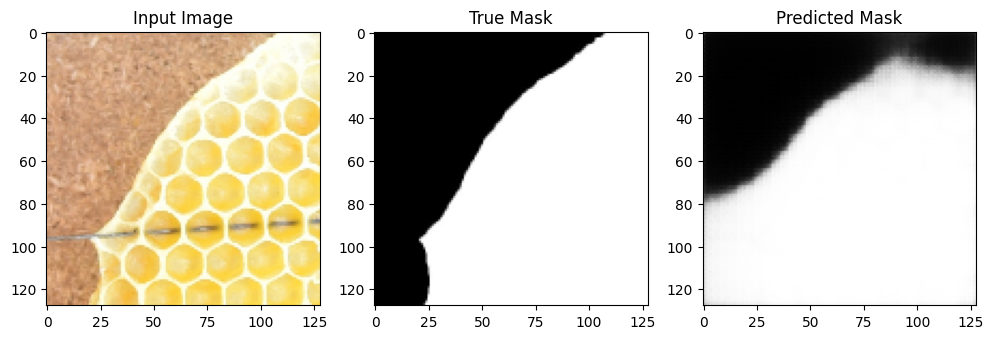

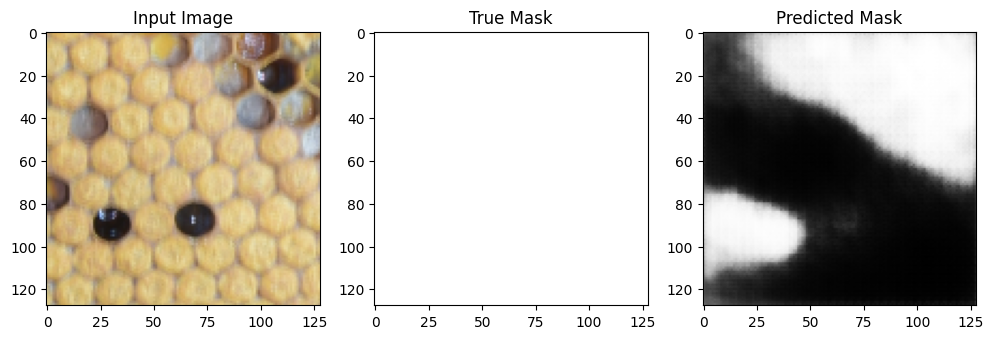

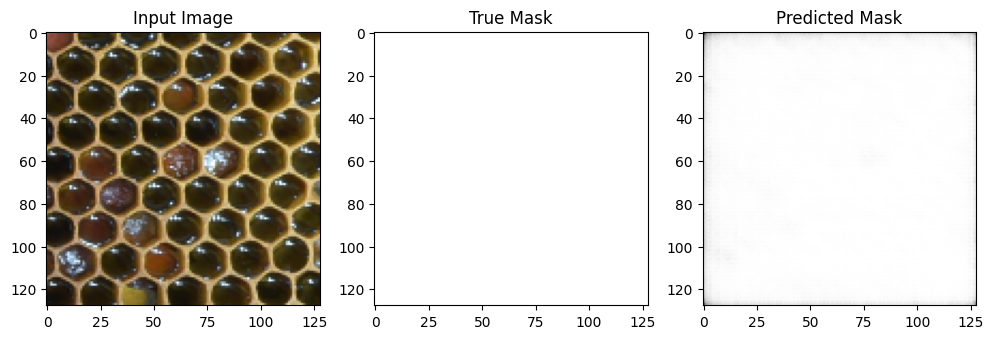

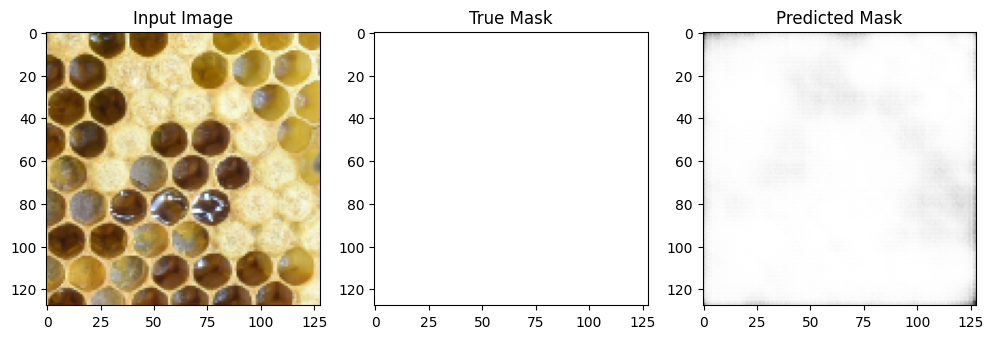

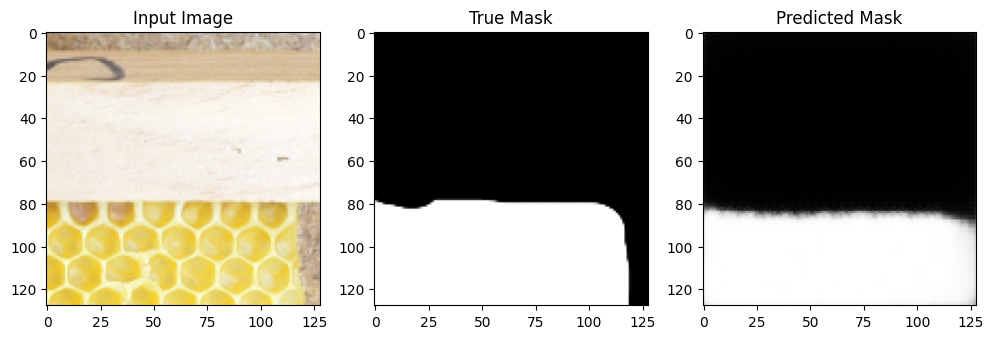

In [28]:
# Predictions
for images, masks in test_dataset.skip(1).take(1):
    predictions = model.predict(images)
    for i in range(5):  # Show 5 examples
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(images[i])
        plt.title('Input Image')
        plt.subplot(132)
        plt.imshow(np.squeeze(masks[i]), cmap='gray', vmin=0, vmax=1)
        plt.title('True Mask')
        plt.subplot(133)
        plt.imshow(np.squeeze(predictions[i]), cmap='gray')
        plt.title('Predicted Mask')
        plt.show()